In [6]:
import os
import cv2
import csv
import numpy as np
import pandas as pd
import mediapipe as mp
import tensorflow as tf
import plotly.express as px 
from tqdm.notebook import tqdm
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from sklearn.model_selection import train_test_split, GroupShuffleSplit 
from IPython.display import HTML

2023-08-24 18:46:20.877674: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/dimeji/Documents/Projects/sign_to_text/sign_env/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [7]:
# If True, processing data from scratch
# If False, loads preprocessed data
PREPROCESS_DATA = True
TRAIN_MODEL = True
# True: use 10% of participants as validation set
# False: use all data for training -> gives better LB result
USE_VAL = False
N_ROWS = 543
N_DIMS = 3
DIM_NAMES = ['x', 'y', 'z']
SEED = 42
NUM_CLASSES = 250

INPUT_SIZE = 64

BATCH_ALL_SIGNS_N = 3
BATCH_SIZE = 256
# N_EPOCHS =250
LR_MAX = 1e-3
# LR_MAX = 0.005 # #3
# LR_MAX = 0.00155 # #3
N_WARMUP_EPOCHS = 50
WD_RATIO = 0.05
MASK_VAL = 4237
N_EPOCHS = 30
VERBOSE = 1

In [8]:
USE_TYPES = ['left_hand', 'pose', 'right_hand']
LHAND = np.arange(468, 489) # 21
RHAND = np.arange(522, 543) # 21
# POSE  = np.arange(489, 522)# 33
FACE  = np.arange(0,468) #468
LIP = np.array([ 0, 
    61, 185, 40, 39, 37, 267, 269, 270, 409,
    291, 146, 91, 181, 84, 17, 314, 405, 321, 375,
    78, 191, 80, 81, 82, 13, 312, 311, 310, 415,
    95, 88, 178, 87, 14, 317, 402, 318, 324, 308,
])
LPOSE = np.array([502, 504, 506, 508, 510])
RPOSE = np.array([503, 505, 507, 509, 511])


In [9]:
# Concatenate the relevant landmarks for each dominant hand scenario
left_hand_dominant = np.concatenate((LIP, LHAND, LPOSE))
right_hand_dominant = np.concatenate((LIP, RHAND, RPOSE))
# landmarks = np.concatenate((LIP, RHAND, LHAND, POSE))
hand_index = np.concatenate((LHAND, RHAND), axis = 0)

#Landmark Indices in preprocess data
hands_index = np.argwhere(np.isin(left_hand_dominant, hand_index)).squeeze()
lip_index = np.argwhere(np.isin(left_hand_dominant, LIP)).squeeze()
left_hand_index = np.argwhere(np.isin(left_hand_dominant, LHAND)).squeeze()
right_hand_index = np.argwhere(np.isin(left_hand_dominant, RHAND)).squeeze()
pose_index = np.argwhere(np.isin(left_hand_dominant, LPOSE)).squeeze()
n_cols = left_hand_dominant.size

In [10]:
print(f'# HAND_IDXS: {len(hands_index)}, N_COLS: {n_cols}')

# HAND_IDXS: 21, N_COLS: 66


In [11]:
LIPS_START = 0
LEFT_HAND_START = lip_index.size
RIGHT_HAND_START = LEFT_HAND_START + left_hand_index.size
POSE_START = RIGHT_HAND_START + right_hand_index.size
print(f'LIPS_START: {LIPS_START}, LEFT_HAND_START: {LEFT_HAND_START}, RIGHT_HAND_START: {RIGHT_HAND_START}, POSE_START: {POSE_START}')

LIPS_START: 0, LEFT_HAND_START: 40, RIGHT_HAND_START: 61, POSE_START: 61


In [8]:
data_2 = pd.read_parquet('/Users/dimeji/Documents/Projects/Sign Language/sign_data/asl-signs/train_landmark_files/2044/635217.parquet')

In [12]:
BASE_DIR = 'asl-signs'
train = pd.read_csv(f'{BASE_DIR}/train.csv')

In [12]:
PREPROCESS_DATA = False
SEED = 42

In [13]:
# Read Training Data
if PREPROCESS_DATA:
    train = pd.read_csv(f'{BASE_DIR}/train.csv').sample(int(5e3), random_state=SEED)
else:
    train = pd.read_csv(f'{BASE_DIR}/train.csv')

N_SAMPLES = len(train)
print(f'N_SAMPLES: {N_SAMPLES}')

N_SAMPLES: 5000


In [ ]:
train

,path,participant_id,sequence_id,sign
56533,train_landmark_files/28656/3311214787.parquet,28656,3311214787,sticky
63119,train_landmark_files/53618/3588192588.parquet,53618,3588192588,before
8760,train_landmark_files/4718/1363575346.parquet,4718,1363575346,pretty
93310,train_landmark_files/37779/951199059.parquet,37779,951199059,hen
44842,train_landmark_files/36257/283190141.parquet,36257,283190141,tomorrow
...,...,...,...,...
39105,train_landmark_files/37779/2599365965.parquet,37779,2599365965,dry
6658,train_landmark_files/32319/1275821842.parquet,32319,1275821842,mitten
76714,train_landmark_files/28656/4140656184.parquet,28656,4140656184,stairs
39645,train_landmark_files/49445/2623313860.parquet,49445,2623313860,radio


In [14]:
# Get complete file path to file
def get_file_path(path):
    return f'sign_data/asl-signs/{path}'

train['file_path'] = train['path'].apply(get_file_path)

In [ ]:
train

,path,participant_id,sequence_id,sign,file_path
56533,train_landmark_files/28656/3311214787.parquet,28656,3311214787,sticky,sign_data/asl-signs/train_landmark_files/28656...
63119,train_landmark_files/53618/3588192588.parquet,53618,3588192588,before,sign_data/asl-signs/train_landmark_files/53618...
8760,train_landmark_files/4718/1363575346.parquet,4718,1363575346,pretty,sign_data/asl-signs/train_landmark_files/4718/...
93310,train_landmark_files/37779/951199059.parquet,37779,951199059,hen,sign_data/asl-signs/train_landmark_files/37779...
44842,train_landmark_files/36257/283190141.parquet,36257,283190141,tomorrow,sign_data/asl-signs/train_landmark_files/36257...
...,...,...,...,...,...
39105,train_landmark_files/37779/2599365965.parquet,37779,2599365965,dry,sign_data/asl-signs/train_landmark_files/37779...
6658,train_landmark_files/32319/1275821842.parquet,32319,1275821842,mitten,sign_data/asl-signs/train_landmark_files/32319...
76714,train_landmark_files/28656/4140656184.parquet,28656,4140656184,stairs,sign_data/asl-signs/train_landmark_files/28656...
39645,train_landmark_files/49445/2623313860.parquet,49445,2623313860,radio,sign_data/asl-signs/train_landmark_files/49445...


### Ordinal Encode Sign

In [15]:
import json

with open('asl-signs/sign_to_prediction_index_map.json') as f: 
    sign_map = json.load(f)

signs = list(sign_map)


In [16]:
signs[:5]

['TV', 'after', 'airplane', 'all', 'alligator']

In [17]:
def mapping_sign_code(sign: str):
    return sign_map[sign]

In [18]:
train['sign_code'] = train['sign'].apply(mapping_sign_code)

In [19]:
from sklearn.preprocessing import LabelEncoder

# Instantiate the encoder
le = LabelEncoder()

# Fit the encoder and transform the 'sign' column
train['sign_code'] = le.fit_transform(train['sign'])

# Create dictionaries for mapping
SIGN2ORD = dict(zip(le.classes_, le.transform(le.classes_)))
ORD2SIGN = dict(zip(le.transform(le.classes_), le.classes_))



In [ ]:
ROWS_PER_FRAME = 543  

def load_relevant_data_subset(pq_path):
    data_columns = ['x', 'y', 'z']
    data = pd.read_parquet(pq_path, columns=data_columns)
    n_frames = int(len(data) / ROWS_PER_FRAME)
    data = data.values.reshape(n_frames, ROWS_PER_FRAME, len(data_columns))
    return data.astype(np.float32)

In [ ]:
def pad_edge(t, repeats, side):
    if side == 'LEFT':
        return tf.concat((tf.repeat(t[:1], repeats=repeats, axis=0), t), axis=0)
    elif side == 'RIGHT':
        return tf.concat((t, tf.repeat(t[-1:], repeats=repeats, axis=0)), axis=0)


### Preprocessing 

In [21]:
"""
Tensorflow layer to process data within TFLite.
To avoid external dependencies, data processing is embedded within the model.
"""
class TFLitePreprocessLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(TFLitePreprocessLayer, self).__init__()

    @tf.function(input_signature=(tf.TensorSpec(shape=[None, N_ROWS, N_DIMS], dtype=tf.float32),))
    def call(self, inputData):

        totalFrames = tf.shape(inputData)[0]

        # Calculate the dominant hand based on sum of absolute coordinates
        leftSum = tf.math.reduce_sum(tf.where(tf.math.is_nan(tf.gather(inputData, LHAND, axis=1)), 0, 1))
        rightSum = tf.math.reduce_sum(tf.where(tf.math.is_nan(tf.gather(inputData, RHAND, axis=1)), 0, 1))
        isLeftDominant = leftSum >= rightSum

        handIndices = LHAND if isLeftDominant else RHAND
        framesWithHand = tf.math.reduce_sum(tf.where(tf.math.is_nan(tf.gather(inputData, handIndices, axis=1)), 0, 1), axis=[1, 2])
        validFrameIndices = tf.squeeze(tf.where(framesWithHand > 0), axis=1)

        processedData = tf.gather(inputData, validFrameIndices, axis=0)
        validFrameIndices = tf.cast(validFrameIndices, tf.float32)
        validFrameIndices -= tf.reduce_min(validFrameIndices)

        frameCount = tf.shape(processedData)[0]

        landmarkColumns = left_hand_dominant if isLeftDominant else right_hand_dominant
        processedData = tf.gather(processedData, landmarkColumns, axis=1)

        # Check if video fits within the input size
        if frameCount < INPUT_SIZE:
            validFrameIndices = tf.pad(validFrameIndices, [[0, INPUT_SIZE - frameCount]], constant_values=-1)
            processedData = tf.pad(processedData, [[0, INPUT_SIZE - frameCount], [0, 0], [0, 0]], constant_values=0)
            processedData = tf.where(tf.math.is_nan(processedData), 0.0, processedData)
            return processedData, validFrameIndices
        else:
            # Handling videos larger than the input size
            if frameCount < INPUT_SIZE ** 2:
                factor = tf.math.floordiv(INPUT_SIZE * INPUT_SIZE, totalFrames)
                processedData = tf.repeat(processedData, repeats=factor, axis=0)
                validFrameIndices = tf.repeat(validFrameIndices, repeats=factor, axis=0)

            adjustedSize = tf.math.floordiv(len(processedData), INPUT_SIZE)
            if tf.math.mod(len(processedData), INPUT_SIZE) > 0:
                adjustedSize += 1

            requiredPadding = (adjustedSize * INPUT_SIZE) - len(processedData) if adjustedSize == 1 else (adjustedSize * INPUT_SIZE) % len(processedData)
            padLeft = tf.math.floordiv(requiredPadding, 2) + tf.math.floordiv(INPUT_SIZE, 2)
            padRight = padLeft + (1 if tf.math.mod(requiredPadding, 2) > 0 else 0)

            processedData = self._addPadding(processedData, padLeft, 'LEFT')
            processedData = self._addPadding(processedData, padRight, 'RIGHT')
            validFrameIndices = self._addPadding(validFrameIndices, padLeft, 'LEFT')
            validFrameIndices = self._addPadding(validFrameIndices, padRight, 'RIGHT')

            processedData = tf.reshape(processedData, [INPUT_SIZE, -1, n_cols, N_DIMS])
            validFrameIndices = tf.reshape(validFrameIndices, [INPUT_SIZE, -1])
            
            processedData = tf.experimental.numpy.nanmean(processedData, axis=1)
            validFrameIndices = tf.experimental.numpy.nanmean(validFrameIndices, axis=1)

            processedData = tf.where(tf.math.is_nan(processedData), 0.0, processedData)
            return processedData, validFrameIndices

    def _addPadding(self, tensor, paddingSize, direction):
        if direction == 'LEFT':
            return tf.concat([tf.repeat(tensor[:1], repeats=paddingSize, axis=0), tensor], axis=0)
        else:
            return tf.concat([tensor, tf.repeat(tensor[-1:], repeats=paddingSize, axis=0)], axis=0)

layerInstance = TFLitePreprocessLayer()


In [ ]:
def get_data(file_path): 
    # Load Raw Data
    data_2 = load_relevant_data_subset(file_path)
    # Process Data Using Tensorflow
    data_2 = layerInstance(data_2)
    return data_2

In [ ]:
# def create_dataset(N_SAMPLES, INPUT_SIZE, N_COLS, N_DIMS, file_paths, sign_ords, participant_ids, SEED=42):
def create_dataset():
    # Create arrays to save data
    X = np.zeros([N_SAMPLES,  INPUT_SIZE, n_cols, N_DIMS], dtype=np.float32)
    y = np.zeros([N_SAMPLES ], dtype=np.int32)
    NON_EMPTY_FRAME_IDXS = np.full([N_SAMPLES, INPUT_SIZE], -1, dtype=np.float32)

    # Fill X/y
    for row_idx, (file_path, sign_code) in enumerate(tqdm(train[['file_path', 'sign_code']].itertuples(index=False))):
        # Log message every 5000 samples
        if row_idx == N_SAMPLES: 
            break
        data, non_empty_frame_idxs = get_data(file_path)
        X[row_idx] = data
        y[row_idx] = sign_code
        NON_EMPTY_FRAME_IDXS[row_idx] = non_empty_frame_idxs
        # Sanity check, data should not contain NaN values
        if np.isnan(data).sum() > 0:
            print(row_idx)
            return data

    # Save X/y
    np.save('X.npy', X)
    np.save('y.npy', y)
    np.save('NON_EMPTY_FRAME_IDXS.npy', NON_EMPTY_FRAME_IDXS)
    
    # Save Validation
    splitter = GroupShuffleSplit(test_size=0.10, n_splits=2, random_state=SEED)
    participant_ids = train['participant_id'].values
    train_idxs, val_idxs = next(splitter.split(X, y, groups=participant_ids))

    # Save Train
    X_train = X[train_idxs]
    NON_EMPTY_FRAME_IDXS_TRAIN = NON_EMPTY_FRAME_IDXS[train_idxs]
    y_train = y[train_idxs]
    np.save('X_train.npy', X_train)
    np.save('y_train.npy', y_train)
    np.save('NON_EMPTY_FRAME_IDXS_TRAIN.npy', NON_EMPTY_FRAME_IDXS_TRAIN)

    # Save Validation
    X_val = X[val_idxs]
    NON_EMPTY_FRAME_IDXS_VAL = NON_EMPTY_FRAME_IDXS[val_idxs]
    y_val = y[val_idxs]
    np.save('X_val.npy', X_val)
    np.save('y_val.npy', y_val)
    np.save('NON_EMPTY_FRAME_IDXS_VAL.npy', NON_EMPTY_FRAME_IDXS_VAL)

    # Split Statistics
    print(f'Patient ID Intersection Train/Val: {set(participant_ids[train_idxs]).intersection(participant_ids[val_idxs])}')
    print(f'X_train shape: {X_train.shape}, X_val shape: {X_val.shape}')
    print(f'y_train shape: {y_train.shape}, y_val shape: {y_val.shape}')


create_dataset()

0it [00:00, ?it/s]

Patient ID Intersection Train/Val: set()
X_train shape: (4243, 64, 66, 3), X_val shape: (757, 64, 66, 3)
y_train shape: (4243,), y_val shape: (757,)


In [ ]:
USE_VAL = False
BASE_DIR_2 = '/Users/dimeji/Documents/Projects/Sign Language'
# Load Data
if USE_VAL:
    # Load Train
    X_train = np.load(f'{BASE_DIR_2}/X_train.npy')
    y_train = np.load(f'{BASE_DIR_2}/y_train.npy')
    NON_EMPTY_FRAME_IDXS_TRAIN = np.load(f'{BASE_DIR_2}/NON_EMPTY_FRAME_IDXS_TRAIN.npy')
    # Load Val
    X_val = np.load(f'{BASE_DIR_2}/X_val.npy')
    y_val = np.load(f'{BASE_DIR_2}/y_val.npy')
    NON_EMPTY_FRAME_IDXS_VAL = np.load(f'{BASE_DIR_2}/NON_EMPTY_FRAME_IDXS_VAL.npy')
    # Define validation Data
    validation_data = ({ 'frames': X_val, 'non_empty_frame_idxs': NON_EMPTY_FRAME_IDXS_VAL }, y_val)
else:
    X_train = np.load(f'{BASE_DIR_2}/X.npy')
    y_train = np.load(f'{BASE_DIR_2}/y.npy')
    NON_EMPTY_FRAME_IDXS_TRAIN = np.load(f'{BASE_DIR_2}/NON_EMPTY_FRAME_IDXS.npy')
    validation_data = None


In [ ]:
X_val = np.load(f'{BASE_DIR_2}/X_val.npy')
y_val = np.load(f'{BASE_DIR_2}/y_val.npy')
NON_EMPTY_FRAME_IDXS_VAL = np.load(f'{BASE_DIR_2}/NON_EMPTY_FRAME_IDXS_VAL.npy')

In [ ]:
lip_data = X_train[:, :, :40]
left_hand_data = X_train[:, :, 40:61]
pose_data = X_train[:, :, 61:66]


In [ ]:
LEFT_HANDS_MEAN_X = np.zeros([21], dtype=np.float32)
LEFT_HANDS_MEAN_Y = np.zeros([21], dtype=np.float32)
LEFT_HANDS_STD_X = np.zeros([21], dtype=np.float32)
LEFT_HANDS_STD_Y = np.zeros([21], dtype=np.float32)

for landmark_idx in range(21):
    for coord_idx in range(2):  # we consider only X and Y
        # we remove zero points
        coordinate_data = left_hand_data[:, :, landmark_idx, coord_idx]
        valid_points = coordinate_data[coordinate_data != 0]
        if coord_idx == 0:  # X
            LEFT_HANDS_MEAN_X[landmark_idx] = valid_points.mean()
            LEFT_HANDS_STD_X[landmark_idx] = valid_points.std()
        else:  # Y
            LEFT_HANDS_MEAN_Y[landmark_idx] = valid_points.mean()
            LEFT_HANDS_STD_Y[landmark_idx] = valid_points.std()

LEFT_HANDS_MEAN = np.array([LEFT_HANDS_MEAN_X, LEFT_HANDS_MEAN_Y]).T
LEFT_HANDS_STD = np.array([LEFT_HANDS_STD_X, LEFT_HANDS_STD_Y]).T



In [ ]:
POSE_MEAN_X = np.zeros([5], dtype=np.float32)
POSE_MEAN_Y = np.zeros([5], dtype=np.float32)
POSE_STD_X = np.zeros([5], dtype=np.float32)
POSE_STD_Y = np.zeros([5], dtype=np.float32)

for landmark_idx in range(5):
    for coord_idx in range(2):  # we consider only X and Y
        # we remove zero points
        coordinate_data = pose_data[:, :, landmark_idx, coord_idx]
        valid_points = coordinate_data[coordinate_data != 0]
        if coord_idx == 0:  # X
            POSE_MEAN_X[landmark_idx] = valid_points.mean()
            POSE_STD_X[landmark_idx] = valid_points.std()
        else:  # Y
            POSE_MEAN_Y[landmark_idx] = valid_points.mean()
            POSE_STD_Y[landmark_idx] = valid_points.std()

POSE_MEAN = np.array([POSE_MEAN_X, POSE_MEAN_Y]).T
POSE_STD = np.array([POSE_STD_X, POSE_STD_Y]).T


In [ ]:
LIP_MEAN_X = np.zeros([40], dtype=np.float32)
LIP_MEAN_Y = np.zeros([40], dtype=np.float32)
LIP_STD_X = np.zeros([40], dtype=np.float32)
LIP_STD_Y = np.zeros([40], dtype=np.float32)

for landmark_idx in range(40):
    for coord_idx in range(2):  # we consider only X and Y
        # we remove zero points
        coordinate_data = lip_data[:, :, landmark_idx, coord_idx]
        valid_points = coordinate_data[coordinate_data != 0]
        if coord_idx == 0:  # X
            LIP_MEAN_X[landmark_idx] = valid_points.mean()
            LIP_STD_X[landmark_idx] = valid_points.std()
        else:  # Y
            LIP_MEAN_Y[landmark_idx] = valid_points.mean()
            LIP_STD_Y[landmark_idx] = valid_points.std()

LIP_MEAN = np.array([LIP_MEAN_X, LIP_MEAN_Y]).T
LIP_STD = np.array([LIP_STD_X, LIP_STD_Y]).T

In [ ]:
NUM_CLASSES = 250
NUM_BLOCKS = 3
N_ROWS = 543
N_DIMS = 3

# final embedding and transformer embedding size
UNITS = 376 # WAS 512

# Transformer
MLP_RATIO = 4

# Dropout
MLP_DROPOUT_RATIO = 0.30 # WAS 0.40
CLASSIFIER_DROPOUT_RATIO = 0.10

# Initiailizers
INIT_HE_UNIFORM = tf.keras.initializers.he_uniform
INIT_GLOROT_UNIFORM = tf.keras.initializers.glorot_uniform
INIT_ZEROS = tf.keras.initializers.constant(0.0)
# Activations
GELU = tf.keras.activations.gelu
BATCH_ALL_SIGNS_N = 3

In [ ]:
# Custom sampler to get a batch containing N times all signs
def get_train_batch_all_signs(X, y, NON_EMPTY_FRAME_IDXS, n=BATCH_ALL_SIGNS_N):
    # Arrays to store batch in
    X_batch = np.zeros([NUM_CLASSES*n, INPUT_SIZE, n_cols, N_DIMS], dtype=np.float32)
    y_batch = np.arange(0, NUM_CLASSES, step=1/n, dtype=np.float32).astype(np.int64)
    non_empty_frame_idxs_batch = np.zeros([NUM_CLASSES*n, INPUT_SIZE], dtype=np.float32)
    
    # Dictionary mapping ordinally encoded sign to corresponding sample indices
    CLASS2IDXS = {}
    for i in range(NUM_CLASSES):
        CLASS2IDXS[i] = np.argwhere(y == i).squeeze().astype(np.int32)
            
    while True:
        # Fill batch arrays
        for i in range(NUM_CLASSES):
            idxs = np.random.choice(CLASS2IDXS[i], n)
            X_batch[i*n:(i+1)*n] = X[idxs]
            non_empty_frame_idxs_batch[i*n:(i+1)*n] = NON_EMPTY_FRAME_IDXS[idxs]
        yield { 'frames': X_batch, 'non_empty_frame_idxs': non_empty_frame_idxs_batch }, y_batch

In [ ]:
print(f'X_train shape is {X_train.shape}')
print(f'y_train shape is {y_train.shape}')
print(f'Non_Empty_Index shape is {NON_EMPTY_FRAME_IDXS_TRAIN.shape}')

X_train shape is (5000, 64, 66, 3)
y_train shape is (5000,)
Non_Empty_Index shape is (5000, 64)


In [ ]:
dummy_dataset = get_train_batch_all_signs(X_train, y_train, NON_EMPTY_FRAME_IDXS_TRAIN)
X_batch, y_batch = next(dummy_dataset)

for k, v in X_batch.items():
    print(f'{k} shape: {v.shape}, dtype: {v.dtype}')

# Batch shape/dtype
print(f'y_batch shape: {y_batch.shape}, dtype: {y_batch.dtype}')
# Verify each batch contains each sign exactly N times
display(pd.Series(y_batch).value_counts().to_frame('Counts'))

frames shape: (750, 64, 66, 3), dtype: float32
non_empty_frame_idxs shape: (750, 64), dtype: float32
y_batch shape: (750,), dtype: int64


,Counts
0,3
171,3
158,3
159,3
160,3
...,...
88,3
89,3
90,3
91,3


### TRANSFORMER

In [ ]:
# The `LandmarkEmbedding` class is responsible for generating embeddings for a specific type of landmark.
class LandmarkEmbedding(tf.keras.Model):
    def __init__(self, units, name):
        super(LandmarkEmbedding, self).__init__(name=f'{name}_embedding')
        self.units = units
        
    def build(self, input_shape):
        # The 'empty_embedding' represents the case when a landmark is missing from a given frame. EMBEDDING FOR WHEN LANDMARK IS MISSING FROM A FRAME
        # It is initialized as a zero vector of size equal to `units`.
        self.empty_embedding = self.add_weight(
            name=f'{self.name}_empty_embedding',
            shape=[self.units],
            initializer=INIT_ZEROS,
        )
        '''
        A Dense Neural Network Layer is being used to map the input data to a point (or a vector) in the embedding space. 
        Therefore similar or related input data are being mapped to points that are close together in the embedding space, 
        while unrelated or dissimilar data will be mapped to points that are further apart.

        The coordinates of the landmarks are transformed from their original space (where they might just represent spatial
        coordinates) to an "embedding space" where the coordinates carry more semantic meaning that can help the model understand
        the gestures or signs being made.
        '''
        # Transforming the landmark data(Lips, Hands, Pose) into the embedding space by passing the data through two fully connected 'dense' layers with GELU activations.
        self.dense = tf.keras.Sequential([
            tf.keras.layers.Dense(self.units, name=f'{self.name}_dense_1', use_bias=False, kernel_initializer='glorot_uniform'),
            tf.keras.layers.Activation('gelu'),
            tf.keras.layers.Dense(self.units, name=f'{self.name}_dense_2', use_bias=False, kernel_initializer='he_uniform'),
        ], name=f'{self.name}_dense')

    def call(self, x):
        # If a landmark is missing from a frame (indicated by a zero sum of the landmark coordinates), 
        # the 'empty_embedding' is returned. Otherwise, the dense layers are applied to generate the embedding.
        embedding_output = tf.where(
            tf.reduce_sum(x, axis=2, keepdims=True) == 0,
            self.empty_embedding,
            self.dense(x),
        )
        return embedding_output


In [ ]:
LIPS_UNITS = 384
HANDS_UNITS = 384
POSE_UNITS = 384
# final embedding and transformer embedding size
UNITS = 512
WD_RATIO = 0.05
INPUT_SIZE = 64 
N_DIMS = 3



In [ ]:
#DIMEJI The `Embedding` class generates the final embeddings for all landmarks and combines them.
class Embedding(tf.keras.Model):
    def __init__(self):
        super(Embedding, self).__init__()
        # self.input_size = input_size
        # self.units = units
    def get_diffs(self, l):
        S = l.shape[2]
        other = tf.expand_dims(l, 3)
        other = tf.repeat(other, S, axis=3)
        other = tf.transpose(other, [0,1,3,2])
        diffs = tf.expand_dims(l, 3) - other
        diffs = tf.reshape(diffs, [-1, INPUT_SIZE, S*S])
        return diffs
                
    def build(self, input_shape):
        # 'positional_embedding' initialized with zero
        self.positional_embedding = tf.keras.layers.Embedding(INPUT_SIZE+1, UNITS, embeddings_initializer=INIT_ZEROS)

        # Create the landmark-specific embedding layers
        self.lips_embedding = LandmarkEmbedding(LIPS_UNITS, 'lips')
        self.left_hand_embedding = LandmarkEmbedding(HANDS_UNITS, 'left_hand')
        self.pose_embedding = LandmarkEmbedding(POSE_UNITS, 'pose')

        # The weights for combining the landmark embeddings. Initialized to zeros, they will be learned during training.
        self.landmark_weights = tf.Variable(tf.zeros([3], dtype=tf.float32), name='landmark_weights')
        
        # A couple of dense layers to further process the combined embeddings
        self.fc = tf.keras.Sequential([
            tf.keras.layers.Dense(UNITS, name='fully_connected_1', use_bias=False, kernel_initializer='glorot_uniform'),
            tf.keras.layers.Activation('gelu'),
            tf.keras.layers.Dense(UNITS, name='fully_connected_2', use_bias=False, kernel_initializer='he_uniform'),
        ], name='fc')

    def call(self, lips0, left_hand0, pose0, non_empty_frame_idxs, training=False):
        # Embed the landmarks using the respective embedding layers
        lips_embedding = self.lips_embedding(lips0)
        left_hand_embedding = self.left_hand_embedding(left_hand0)
        pose_embedding = self.pose_embedding(pose0)


        # The embeddings are stacked together along a new dimension, and then weighted and summed to form a single vector.
        # The weights are normalized using a softmax function, which ensures that they sum to 1.
        x = tf.stack((lips_embedding, left_hand_embedding, pose_embedding), axis=3)
        x = x * tf.nn.softmax(self.landmark_weights)
        x = tf.reduce_sum(x, axis=3)


        # Pass the combined embedding through the two fully connected layers
        x = self.fc(x)
        # print(f'X Shape : {x.shape}')

        # Add the positional embedding
        max_frame_idxs = tf.clip_by_value(
                tf.reduce_max(non_empty_frame_idxs, axis=1, keepdims=True),
                1,
                np.PINF,
            )
        # print('Max Frame Index')
        normalised_non_empty_frame_idxs = tf.where(
            tf.math.equal(non_empty_frame_idxs, -1.0),
            INPUT_SIZE,
            tf.cast(
                non_empty_frame_idxs / max_frame_idxs * INPUT_SIZE,
                tf.int32,
            ),
        )
        x = x + self.positional_embedding(normalised_non_empty_frame_idxs)

        return x

In [ ]:
# scaled dot-product and Multiheadattention Transformer
def scaled_dot_product(q,k,v, softmax, attention_mask):
    #calculates Q . K(transpose)
    qkt = tf.matmul(q,k,transpose_b=True)
    #caculates scaling factor
    dk = tf.math.sqrt(tf.cast(q.shape[-1],dtype=tf.float32))
    scaled_qkt = qkt/dk
    softmax = softmax(scaled_qkt, mask=attention_mask)
    
    z = tf.matmul(softmax,v)
    #shape: (m,Tx,depth), same shape as q,k,v
    return z

class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self,d_model,num_of_heads):
        super(MultiHeadAttention,self).__init__()
        self.d_model = d_model
        self.num_of_heads = num_of_heads
        self.depth = d_model//num_of_heads
        self.wq = [tf.keras.layers.Dense(self.depth) for i in range(num_of_heads)]
        self.wk = [tf.keras.layers.Dense(self.depth) for i in range(num_of_heads)]
        self.wv = [tf.keras.layers.Dense(self.depth) for i in range(num_of_heads)]
        self.wo = tf.keras.layers.Dense(d_model)
        self.softmax = tf.keras.layers.Softmax()
        
    def call(self,x, attention_mask):
        
        multi_attn = []
        for i in range(self.num_of_heads):
            Q = self.wq[i](x)
            K = self.wk[i](x)
            V = self.wv[i](x)
            multi_attn.append(scaled_dot_product(Q,K,V, self.softmax, attention_mask))
            
        multi_head = tf.concat(multi_attn,axis=-1)
        multi_head_attention = self.wo(multi_head)
        return multi_head_attention

In [ ]:
# Full Transformer
class Transformer(tf.keras.Model):
    def __init__(self, num_blocks):
        super(Transformer, self).__init__(name='transformer')
        self.num_blocks = num_blocks
    
    def build(self, input_shape):
        self.ln_1s = []
        self.mhas = []
        self.ln_2s = []
        self.mlps = []
        # Make Transformer Blocks
        for i in range(self.num_blocks):
            # Multi Head Attention
            self.mhas.append(MultiHeadAttention(UNITS, 8))
            # Multi Layer Perception
            self.mlps.append(tf.keras.Sequential([
                tf.keras.layers.Dense(UNITS * MLP_RATIO, activation=GELU, kernel_initializer=INIT_GLOROT_UNIFORM),
                tf.keras.layers.Dropout(MLP_DROPOUT_RATIO),
                tf.keras.layers.Dense(UNITS, kernel_initializer=INIT_HE_UNIFORM),
            ]))

    def call(self, x, attention_mask):
        # Iterate input over transformer blocks
        for mha, mlp in zip(self.mhas, self.mlps):
            x = x + mha(x, attention_mask)
            x = x + mlp(x)

        return x

In [4]:
# source:: https://stackoverflow.com/questions/60689185/label-smoothing-for-sparse-categorical-crossentropy
def scce_with_ls(y_true, y_pred):
    # One Hot Encode Sparsely Encoded Target Sign
    y_true = tf.cast(y_true, tf.int32)
    y_true = tf.one_hot(y_true, NUM_CLASSES, axis=1)
    y_true = tf.squeeze(y_true, axis=2)
    # Categorical Crossentropy with native label smoothing support
    return tf.keras.losses.categorical_crossentropy(y_true, y_pred, label_smoothing=0.25)

In [ ]:
#Dimeji get_model
def get_model():
    # Inputs
    frames = tf.keras.layers.Input([INPUT_SIZE, n_cols, N_DIMS], dtype=tf.float32, name='frames')
    non_empty_frame_idxs = tf.keras.layers.Input([INPUT_SIZE], dtype=tf.float32, name='non_empty_frame_idxs')

    # Padding Mask
    mask0 = tf.cast(tf.math.not_equal(non_empty_frame_idxs, -1), tf.float32)
    mask0 = tf.expand_dims(mask0, axis=2)
    # Random Frame Masking
    mask = tf.where(
        (tf.random.uniform(tf.shape(mask0)) > 0.25) & tf.math.not_equal(mask0, 0.0),
        1.0,
        0.0,
    )
    # Correct Samples Which are all masked now...
    mask = tf.where(
        tf.math.equal(tf.reduce_sum(mask, axis=[1,2], keepdims=True), 0.0),
        mask0,
        mask,
    )

    x = tf.slice(frames, [0,0,0,0], [-1,INPUT_SIZE, n_cols, 2])

    # LIPS
    lips = tf.slice(x, [0,0,LIPS_START,0], [-1,INPUT_SIZE, 40, 2])
    lips = tf.where(
            tf.math.equal(lips, 0.0),
            0.0,
            (lips - LIP_MEAN) / LIP_STD,
        )

    # LEFT HAND
    left_hand = tf.slice(x, [0,0,40,0], [-1,INPUT_SIZE, 21, 2])
    left_hand = tf.where(
            tf.math.equal(left_hand, 0.0),
            0.0,
            (left_hand - LEFT_HANDS_MEAN) / LEFT_HANDS_STD,
        )

    # POSE
    pose = tf.slice(x, [0,0,61,0], [-1,INPUT_SIZE, 5, 2])
    pose = tf.where(
            tf.math.equal(pose, 0.0),
            0.0,
            (pose - POSE_MEAN) / POSE_STD,
        )

    # Flatten
    lips = tf.reshape(lips, [-1, INPUT_SIZE, 40*2])
    left_hand = tf.reshape(left_hand, [-1, INPUT_SIZE, 21*2])
    pose = tf.reshape(pose, [-1, INPUT_SIZE, 5*2])
    # Embedding
    x = Embedding()(lips, left_hand, pose, non_empty_frame_idxs)
    
    # Encoder Transformer Block 
    x = Transformer(NUM_BLOCKS)(x, mask)
    
    # Pooling
    x = tf.reduce_sum(x * mask, axis=1) / tf.reduce_sum(mask, axis=1)

    # Classifier Dropout
    x = tf.keras.layers.Dropout(CLASSIFIER_DROPOUT_RATIO)(x)
    # Classification Layer
    x = tf.keras.layers.Dense(NUM_CLASSES, activation=tf.keras.activations.softmax, kernel_initializer=INIT_GLOROT_UNIFORM)(x)
    
    outputs = x

    # Create Tensorflow Model
    model = tf.keras.models.Model(inputs=[frames, non_empty_frame_idxs], outputs=outputs)
    
    # Sparse Categorical Cross Entropy With Label Smoothing
    loss = scce_with_ls
    optimizer = tfa.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-5, clipnorm=1.0)
    # TopK Metrics
    metrics = [
        tf.keras.metrics.SparseCategoricalAccuracy(name='acc'),
        tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name='top_5_acc'),
        tf.keras.metrics.SparseTopKCategoricalAccuracy(k=10, name='top_10_acc'),
    ]
    
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    return model

In [ ]:
tf.keras.backend.clear_session()

model_one = get_model()


In [ ]:
# Custom callback to update weight decay with learning rate
class WeightDecayCallback(tf.keras.callbacks.Callback):
    def __init__(self, wd_ratio=WD_RATIO):
        self.step_counter = 0
        self.wd_ratio = wd_ratio
    
    def on_epoch_begin(self, epoch, logs=None):
        model_one.optimizer.weight_decay = model_one.optimizer.learning_rate * self.wd_ratio
        print(f'learning rate: {model_one.optimizer.learning_rate.numpy():.2e}, weight decay: {model_one.optimizer.weight_decay.numpy():.2e}')

In [ ]:
def lrfn(current_step, num_warmup_steps, lr_max, num_cycles=0.5,num_training_steps=N_EPOCHS):
    
    if current_step < num_warmup_steps:
        return lr_max * 2 ** -(num_warmup_steps - current_step)
    else:
        progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))

        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress))) * lr_max

In [ ]:
model_one.summary(expand_nested=True)

In [ ]:
tf.keras.utils.plot_model(model_one, show_shapes=True, show_dtype=True, show_layer_names=True, expand_nested=True, show_layer_activations=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [ ]:
import scipy 

In [ ]:
# Landmark Weights
for w in model_one.get_layer('embedding').weights:
    if 'landmark_weights' in w.name:
        weights = scipy.special.softmax(w)

landmarks = ['lips_embedding', 'left_hand_embedding', 'pose_embedding']

for w, lm in zip(weights, landmarks):
    print(f'{lm} weight: {(w*100):.1f}%')

lips_embedding weight: 33.3%
left_hand_embedding weight: 33.3%
pose_embedding weight: 33.3%


In [ ]:
BATCH_SIZE = 256
LR_MAX = 1e-3
N_WARMUP_EPOCHS = 50
import math

In [ ]:
# Learning rate for encoder
LR_SCHEDULE = [lrfn(step, num_warmup_steps=N_WARMUP_EPOCHS, lr_max=LR_MAX, num_cycles=0.50) for step in range(N_EPOCHS)]

# Learning Rate Callback
lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda step: LR_SCHEDULE[step], verbose=1)

In [ ]:
TRAIN_MODEL = True

In [ ]:
if TRAIN_MODEL:
    # Clear all models in GPU
    tf.keras.backend.clear_session()

    # Get new fresh model
    model = get_model()
    
    # Sanity Check
    model.summary()

    # Actual Training
    history = model.fit(
            x=get_train_batch_all_signs(X_train, y_train, NON_EMPTY_FRAME_IDXS_TRAIN),
            steps_per_epoch=len(X_train) // (NUM_CLASSES * BATCH_ALL_SIGNS_N),
            epochs=N_EPOCHS,
            # Only used for validation data since training data is a generator
            batch_size=BATCH_SIZE,
            validation_data=validation_data,
            callbacks=[
                lr_callback,
                WeightDecayCallback(),
            ],
            verbose = VERBOSE,
        )

(None, 64, 10)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 non_empty_frame_idxs (Inpu  [(None, 64)]                 0         []                            
 tLayer)                                                                                          
                                                                                                  
 tf.math.not_equal (TFOpLam  (None, 64)                   0         ['non_empty_frame_idxs[0][0]']
 bda)                                                                                             
                                                                                                  
 tf.cast (TFOpLambda)        (None, 64)                   0         ['tf.math.not_equal[0][0]']   
                                                                               

In [ ]:
def print_classification_report():
    # Classification report for all signs
    classification_report = sklearn.metrics.classification_report(
            y_val,
            y_val_pred,
            target_names=labels,
            output_dict=True,
        )
    # Round Data for better readability
    classification_report = pd.DataFrame(classification_report).T
    classification_report = classification_report.round(2)
    classification_report = classification_report.astype({
            'support': np.uint16,
        })
    # Add signs
    classification_report['sign'] = [e if e in SIGN2ORD else -1 for e in classification_report.index]
    classification_report['sign_ord'] = classification_report['sign'].apply(SIGN2ORD.get).fillna(-1).astype(np.int16)
    # Sort on F1-score
    classification_report = pd.concat((
        classification_report.head(NUM_CLASSES).sort_values('f1-score', ascending=False),
        classification_report.tail(3),
    ))

    pd.options.display.max_rows = 999
    display(classification_report)

In [ ]:
# Validation Predictions
y_val_pred = model_one.predict({ 'frames': X_val, 'non_empty_frame_idxs': NON_EMPTY_FRAME_IDXS_VAL }, verbose=2).argmax(axis=1)
# Label
labels = [ORD2SIGN.get(i).replace(' ', '_') for i in range(NUM_CLASSES)]

24/24 - 6s - 6s/epoch - 260ms/step


In [ ]:
NUM_CLASSES

250

In [ ]:
len(labels)

250

In [ ]:
classification_report = sklearn.metrics.classification_report(
        y_val,
        y_val_pred,
        target_names=labels,
        output_dict=True,
    )

In [ ]:
import sklearn

In [ ]:
def print_classification_report():
    # Classification report for all signs
    classification_report = sklearn.metrics.classification_report(
            y_val,
            y_val_pred,
            target_names=labels,
            output_dict=True,
        )
    # Round Data for better readability
    classification_report = pd.DataFrame(classification_report).T
    classification_report = classification_report.round(2)
    classification_report = classification_report.astype({
            'support': np.uint16,
        })
    # Add signs
    classification_report['sign'] = [e if e in SIGN2ORD else -1 for e in classification_report.index]
    classification_report['sign_ord'] = classification_report['sign'].apply(SIGN2ORD.get).fillna(-1).astype(np.int16)
    # Sort on F1-score
    classification_report = pd.concat((
        classification_report.head(NUM_CLASSES).sort_values('f1-score', ascending=False),
        classification_report.tail(3),
    ))

    pd.options.display.max_rows = 999
    display(classification_report)
print_classification_report()

In [ ]:
def plot_history_metric(metric, f_best=np.argmax, ylim=None, yscale=None, yticks=None):
    plt.figure(figsize=(20, 10))
    
    values = history.history[metric]
    N_EPOCHS = len(values)
    val = 'val' in ''.join(history.history.keys())
    # Epoch Ticks
    if N_EPOCHS <= 20:
        x = np.arange(1, N_EPOCHS + 1)
    else:
        x = [1, 5] + [10 + 5 * idx for idx in range((N_EPOCHS - 10) // 5 + 1)]

    x_ticks = np.arange(1, N_EPOCHS+1)

    # Validation
    if val:
        val_values = history.history[f'val_{metric}']
        val_argmin = f_best(val_values)
        plt.plot(x_ticks, val_values, label=f'val')

    # summarize history for accuracy
    plt.plot(x_ticks, values, label=f'train')
    argmin = f_best(values)
    plt.scatter(argmin + 1, values[argmin], color='red', s=75, marker='o', label=f'train_best')
    if val:
        plt.scatter(val_argmin + 1, val_values[val_argmin], color='purple', s=75, marker='o', label=f'val_best')

    plt.title(f'Model {metric}', fontsize=24, pad=10)
    plt.ylabel(metric, fontsize=20, labelpad=10)

    if ylim:
        plt.ylim(ylim)

    if yscale is not None:
        plt.yscale(yscale)
        
    if yticks is not None:
        plt.yticks(yticks, fontsize=16)

    plt.xlabel('epoch', fontsize=20, labelpad=10)        
    plt.tick_params(axis='x', labelsize=8)
    plt.xticks(x, fontsize=16) # set tick step to 1 and let x axis start at 1
    plt.yticks(fontsize=16)
    
    plt.legend(prop={'size': 10})
    plt.grid()
    plt.show()



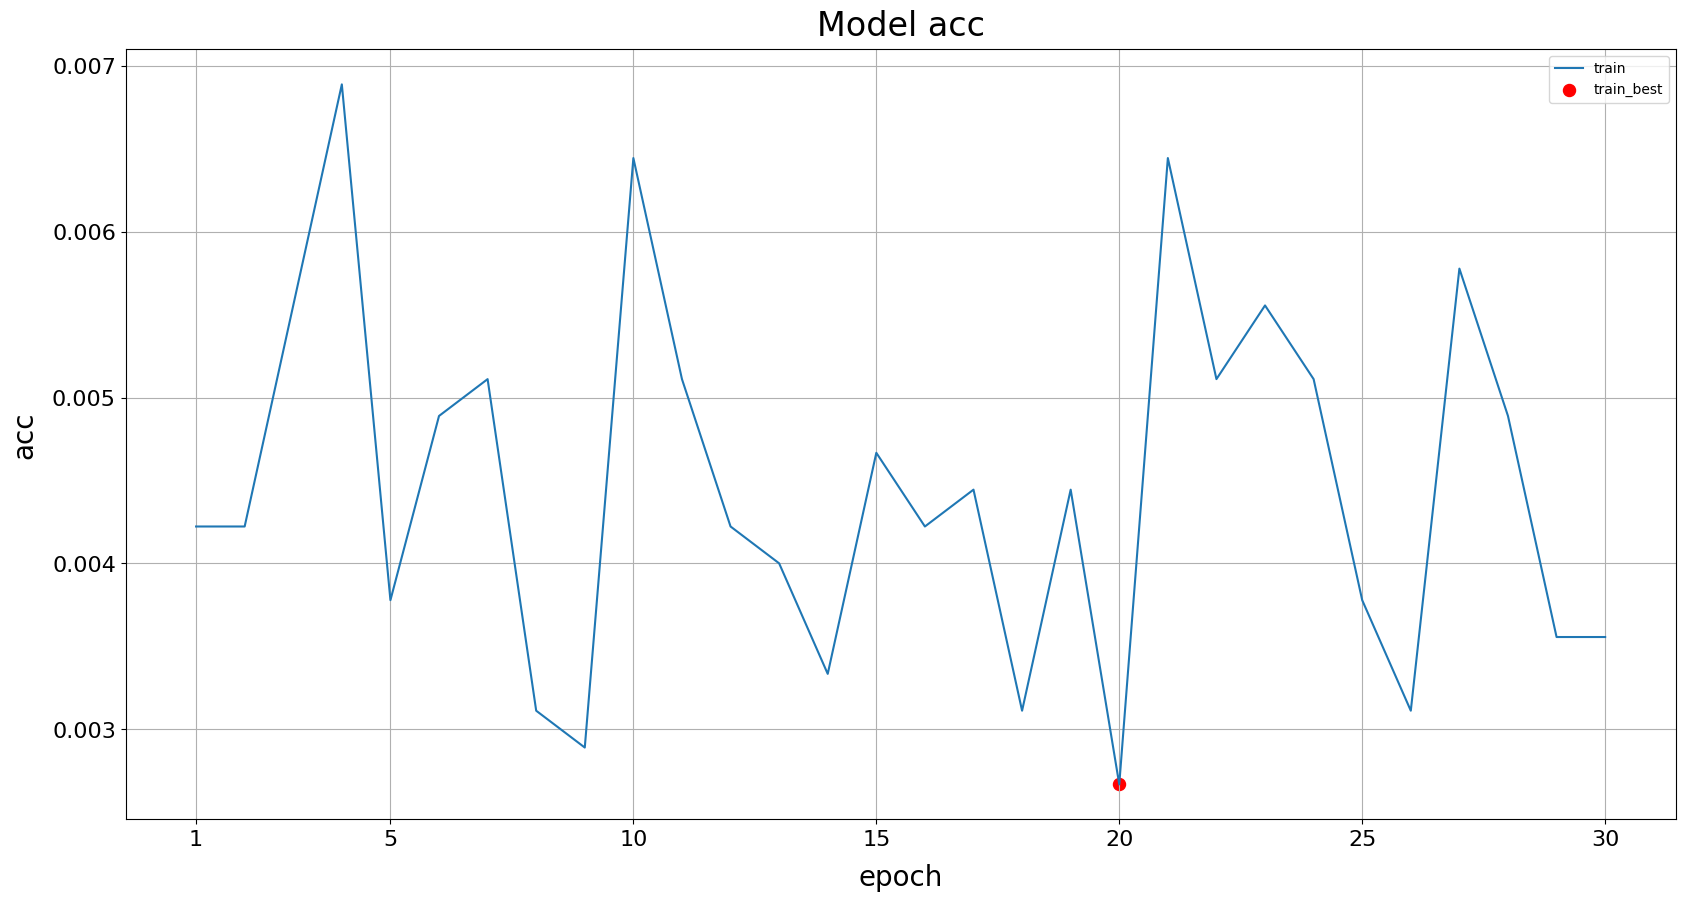

In [ ]:
if TRAIN_MODEL:
    plot_history_metric('loss', f_best=np.argmin)

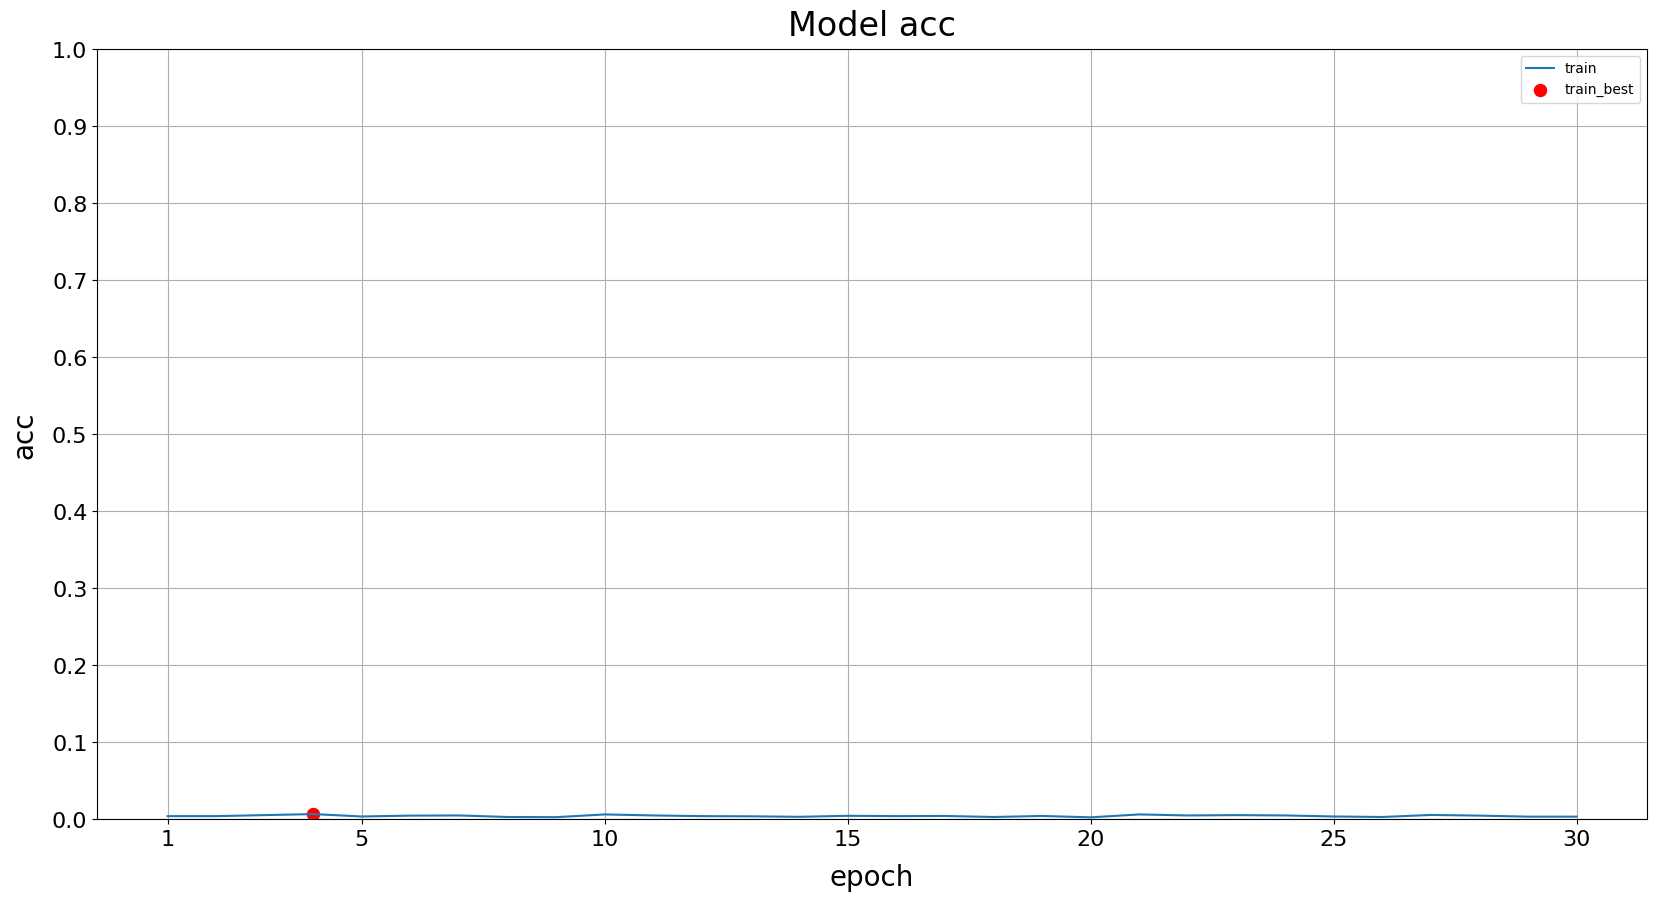

In [ ]:
if TRAIN_MODEL:
    plot_history_metric('acc', ylim=[0,1], yticks=np.arange(0.0, 1.1, 0.1))

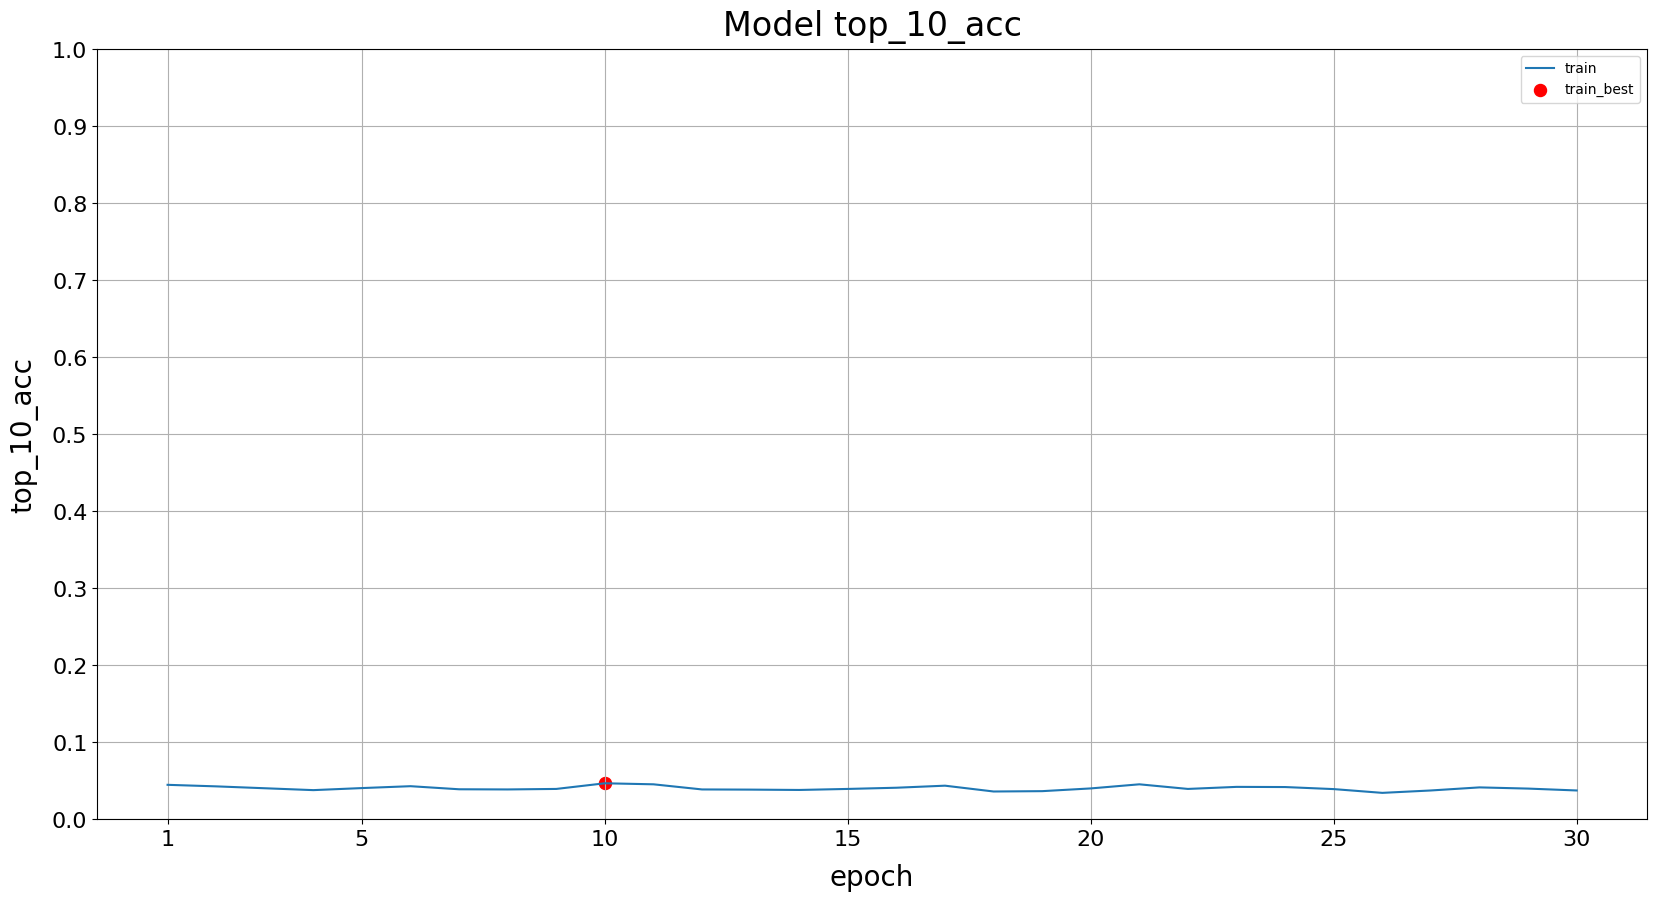

In [ ]:
if TRAIN_MODEL:
    plot_history_metric('top_10_acc', ylim=[0,1], yticks=np.arange(0.0, 1.1, 0.1))

### LSTM

In [ ]:
# univariate multi-step encoder-decoder lstm example
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
class DenseBlock(layers.Layer):
    def __init__(self, units, drop):
        super().__init__()
        self.dense = layers.Dense(units)
        self.norm = layers.LayerNormalization()
        self.relu = layers.Activation("relu")
        self.drop = layers.Dropout(drop)
        
    def call(self, x):
        x = self.dense(x)
        x = self.norm(x)
        x = self.relu(x)
        x = self.drop(x)
        print(x.shape)
        return x

class ClassifierLSTM(layers.Layer):
    def __init__(self, lstm_units, drop):
        super().__init__()
        self.dropout = layers.Dropout(drop)
        self.pool2d = layers.AveragePooling2D(pool_size=(4, 1))
        self.reshape = layers.Reshape((-1, 64))
        self.lstm = layers.LSTM(units=lstm_units, return_sequences=True)
        self.pool1d = layers.AveragePooling1D(pool_size=4)
        self.flat = layers.Flatten()
        self.outputs = layers.Dense(250, activation="softmax", name="predictions")
    
    def call(self, x): 
        x = self.pool2d(x)
        x = self.reshape(x)
        x = self.lstm(x)
        x = self.dropout(x)
        x = self.pool1d(x)
        x = self.flat(x)
        outputs = self.outputs(x)
        return outputs

class ClassifierConvLSTM1D(layers.Layer):
    def __init__(self, lstm_units, drop):
        super().__init__()
        self.expand_dim = layers.Reshape((64, 64, 1))
        self.pool2d = layers.AveragePooling2D(pool_size=(6, 1))
        self.conv_lstm1D = layers.ConvLSTM1D(filters=lstm_units, kernel_size=1)
        self.dropout = layers.Dropout(drop)
        self.flat = layers.Flatten()
        self.outputs = layers.Dense(250, activation="softmax", name="predictions")
    
    def call(self, x):
        x = self.expand_dim(x)
        x = self.pool2d(x)
        x = self.conv_lstm1D(x)
        x = self.dropout(x)
        x = self.flat(x)
        outputs = self.outputs(x)
        print('Done')
        return outputs
                                                                                  

In [ ]:
#Dimeji get_model
def get_lstm_model(encoder_units=[512, 64], drop=0.5, lstm_units=250):
    # Inputs
    frames = tf.keras.layers.Input([INPUT_SIZE, n_cols, N_DIMS], dtype=tf.float32, name='frames')
    non_empty_frame_idxs = tf.keras.layers.Input([INPUT_SIZE], dtype=tf.float32, name='non_empty_frame_idxs')

    # Padding Mask
    mask0 = tf.cast(tf.math.not_equal(non_empty_frame_idxs, -1), tf.float32)
    mask0 = tf.expand_dims(mask0, axis=2)
    # Random Frame Masking
    mask = tf.where(
        (tf.random.uniform(tf.shape(mask0)) > 0.25) & tf.math.not_equal(mask0, 0.0),
        1.0,
        0.0,
    )
    # Correct Samples Which are all masked now...
    mask = tf.where(
        tf.math.equal(tf.reduce_sum(mask, axis=[1,2], keepdims=True), 0.0),
        mask0,
        mask,
    )

    x = tf.slice(frames, [0,0,0,0], [-1,INPUT_SIZE, n_cols, 2])

    # LIPS
    lips = tf.slice(x, [0,0,LIPS_START,0], [-1,INPUT_SIZE, 40, 2])
    lips = tf.where(
            tf.math.equal(lips, 0.0),
            0.0,
            (lips - LIP_MEAN) / LIP_STD,
        )

    # LEFT HAND
    left_hand = tf.slice(x, [0,0,40,0], [-1,INPUT_SIZE, 21, 2])
    left_hand = tf.where(
            tf.math.equal(left_hand, 0.0),
            0.0,
            (left_hand - LEFT_HANDS_MEAN) / LEFT_HANDS_STD,
        )

    # POSE
    pose = tf.slice(x, [0,0,61,0], [-1,INPUT_SIZE, 5, 2])
    pose = tf.where(
            tf.math.equal(pose, 0.0),
            0.0,
            (pose - POSE_MEAN) / POSE_STD,
        )

    # Flatten
    lips = tf.reshape(lips, [-1, INPUT_SIZE, 40*2])
    left_hand = tf.reshape(left_hand, [-1, INPUT_SIZE, 21*2])
    pose = tf.reshape(pose, [-1, INPUT_SIZE, 5*2])
    print(pose.shape)
    # Embedding
    x = Embedding()(lips, left_hand, pose, non_empty_frame_idxs)
    
    # Process through DenseBlock and Classifier
    for units in encoder_units:
        x = DenseBlock(units, drop)(x)
    
    outputs = ClassifierConvLSTM1D(lstm_units, drop)(x)

    # model = tf.keras.Model(inputs=[frames, non_empty_frame_idxs], outputs=outputs)
    # model.compile(
    #     loss=scce_with_ls,
    #     optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    #     metrics=["accuracy"],
    # )   
    model = tf.keras.Model(inputs=[frames, non_empty_frame_idxs], outputs=outputs)
    optimizer = tfa.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-5, clipnorm=1.0)
    # TopK Metrics
    metrics = [
        tf.keras.metrics.SparseCategoricalAccuracy(name='acc'),
        tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name='top_5_acc'),
        tf.keras.metrics.SparseTopKCategoricalAccuracy(k=10, name='top_10_acc'),
    ]
    model.compile(
        loss=scce_with_ls,
        optimizer=optimizer,
        metrics=metrics,
    )    
    return model

In [ ]:
lstm_model = get_lstm_model()

(None, 64, 10)
(None, 64, 512)
(None, 64, 64)
DOne


In [ ]:
N_EPOCHS = 10

In [ ]:
# Actual Training
history = lstm_model.fit(
        x=get_train_batch_all_signs(X_train, y_train, NON_EMPTY_FRAME_IDXS_TRAIN),
        steps_per_epoch=len(X_train) // (NUM_CLASSES * BATCH_ALL_SIGNS_N),
        epochs=N_EPOCHS,
        # Only used for validation data since training data is a generator
        # batch_size=BATCH_SIZE,
        # validation_data=validation_data,
        # callbacks=[
        #     lr_callback,
        #     WeightDecayCallback(),
        # ],
        verbose = VERBOSE,
    )

Epoch 1/10
(None, 64, 512)
(None, 64, 64)
DOne
(None, 64, 512)
(None, 64, 64)
DOne
6/6 [==============================] - 270s 44s/step - loss: 5.5197 - acc: 0.0058 - top_5_acc: 0.0251 - top_10_acc: 0.0480
Epoch 2/10
6/6 [==============================] - 263s 43s/step - loss: 5.4813 - acc: 0.0138 - top_5_acc: 0.0504 - top_10_acc: 0.0882
Epoch 3/10
6/6 [==============================] - 347s 61s/step - loss: 5.3710 - acc: 0.0169 - top_5_acc: 0.0751 - top_10_acc: 0.1307
Epoch 4/10
6/6 [==============================] - 350s 58s/step - loss: 5.2569 - acc: 0.0298 - top_5_acc: 0.1184 - top_10_acc: 0.1960
Epoch 5/10
6/6 [==============================] - 233s 39s/step - loss: 5.1326 - acc: 0.0544 - top_5_acc: 0.1713 - top_10_acc: 0.2598
Epoch 6/10
6/6 [==============================] - 217s 37s/step - loss: 4.9856 - acc: 0.0791 - top_5_acc: 0.2231 - top_10_acc: 0.3342
Epoch 7/10
6/6 [==============================] - 240s 40s/step - loss: 4.8085 - acc: 0.1124 - top_5_acc: 0.3087 - top_10_ac

In [ ]:
def plot_history_metric(metric, f_best=np.argmax, ylim=None, yscale=None, yticks=None):
    plt.figure(figsize=(20, 10))
    
    values = history.history[metric]
    N_EPOCHS = len(values)
    val = 'val' in ''.join(history.history.keys())
    # Epoch Ticks
    if N_EPOCHS <= 20:
        x = np.arange(1, N_EPOCHS + 1)
    else:
        x = [1, 5] + [10 + 5 * idx for idx in range((N_EPOCHS - 10) // 5 + 1)]

    x_ticks = np.arange(1, N_EPOCHS+1)

    # Validation
    if val:
        val_values = history.history[f'val_{metric}']
        val_argmin = f_best(val_values)
        plt.plot(x_ticks, val_values, label=f'val')

    # summarize history for accuracy
    plt.plot(x_ticks, values, label=f'train')
    argmin = f_best(values)
    plt.scatter(argmin + 1, values[argmin], color='red', s=75, marker='o', label=f'train_best')
    if val:
        plt.scatter(val_argmin + 1, val_values[val_argmin], color='purple', s=75, marker='o', label=f'val_best')

    plt.title(f'Model {metric}', fontsize=24, pad=10)
    plt.ylabel(metric, fontsize=20, labelpad=10)

    if ylim:
        plt.ylim(ylim)

    if yscale is not None:
        plt.yscale(yscale)
        
    if yticks is not None:
        plt.yticks(yticks, fontsize=16)

    plt.xlabel('epoch', fontsize=20, labelpad=10)        
    plt.tick_params(axis='x', labelsize=8)
    plt.xticks(x, fontsize=16) # set tick step to 1 and let x axis start at 1
    plt.yticks(fontsize=16)
    
    plt.legend(prop={'size': 10})
    plt.grid()
    plt.show()



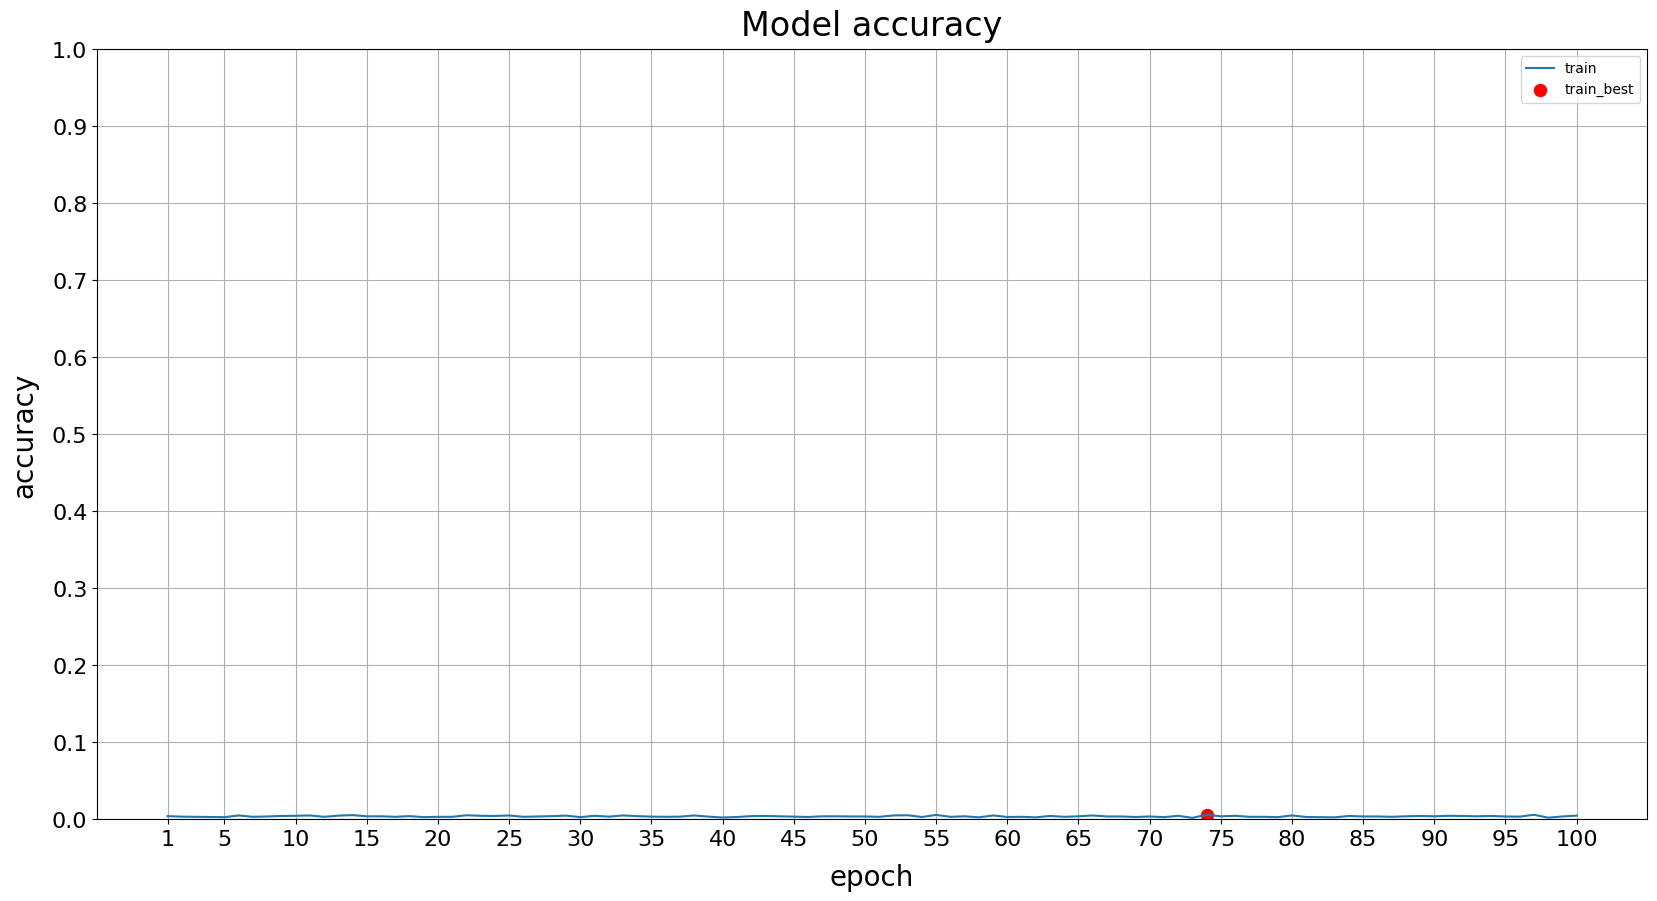

In [ ]:

plot_history_metric('accuracy', ylim=[0,1], yticks=np.arange(0.0, 1.1, 0.1))


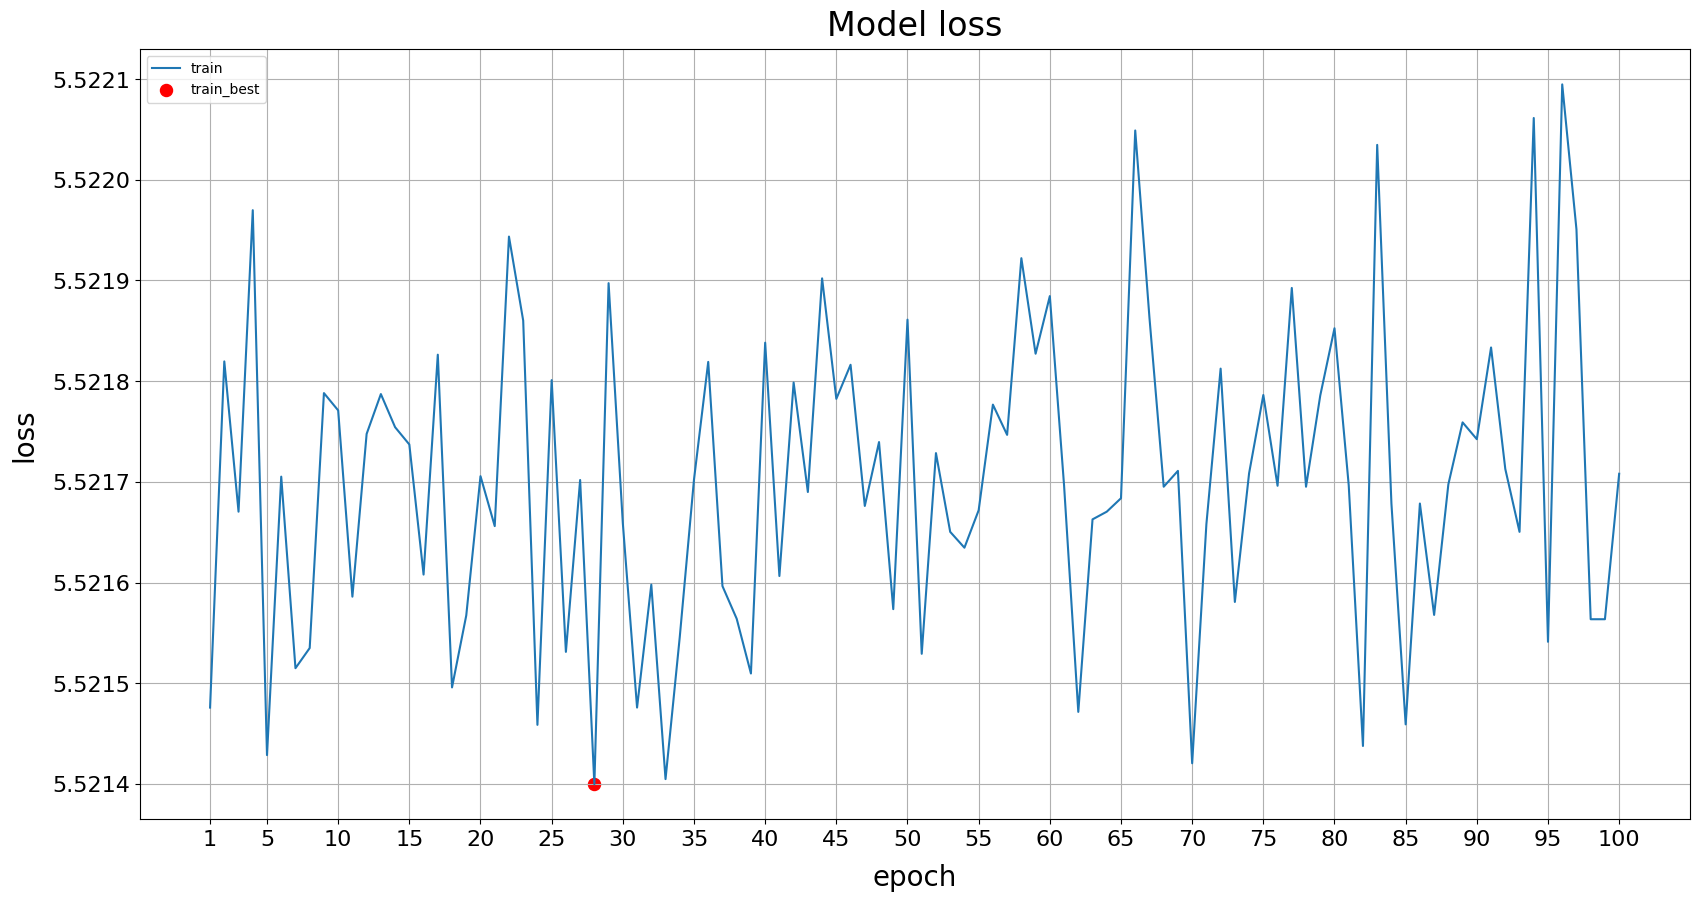

In [ ]:
plot_history_metric('loss', f_best=np.argmin)

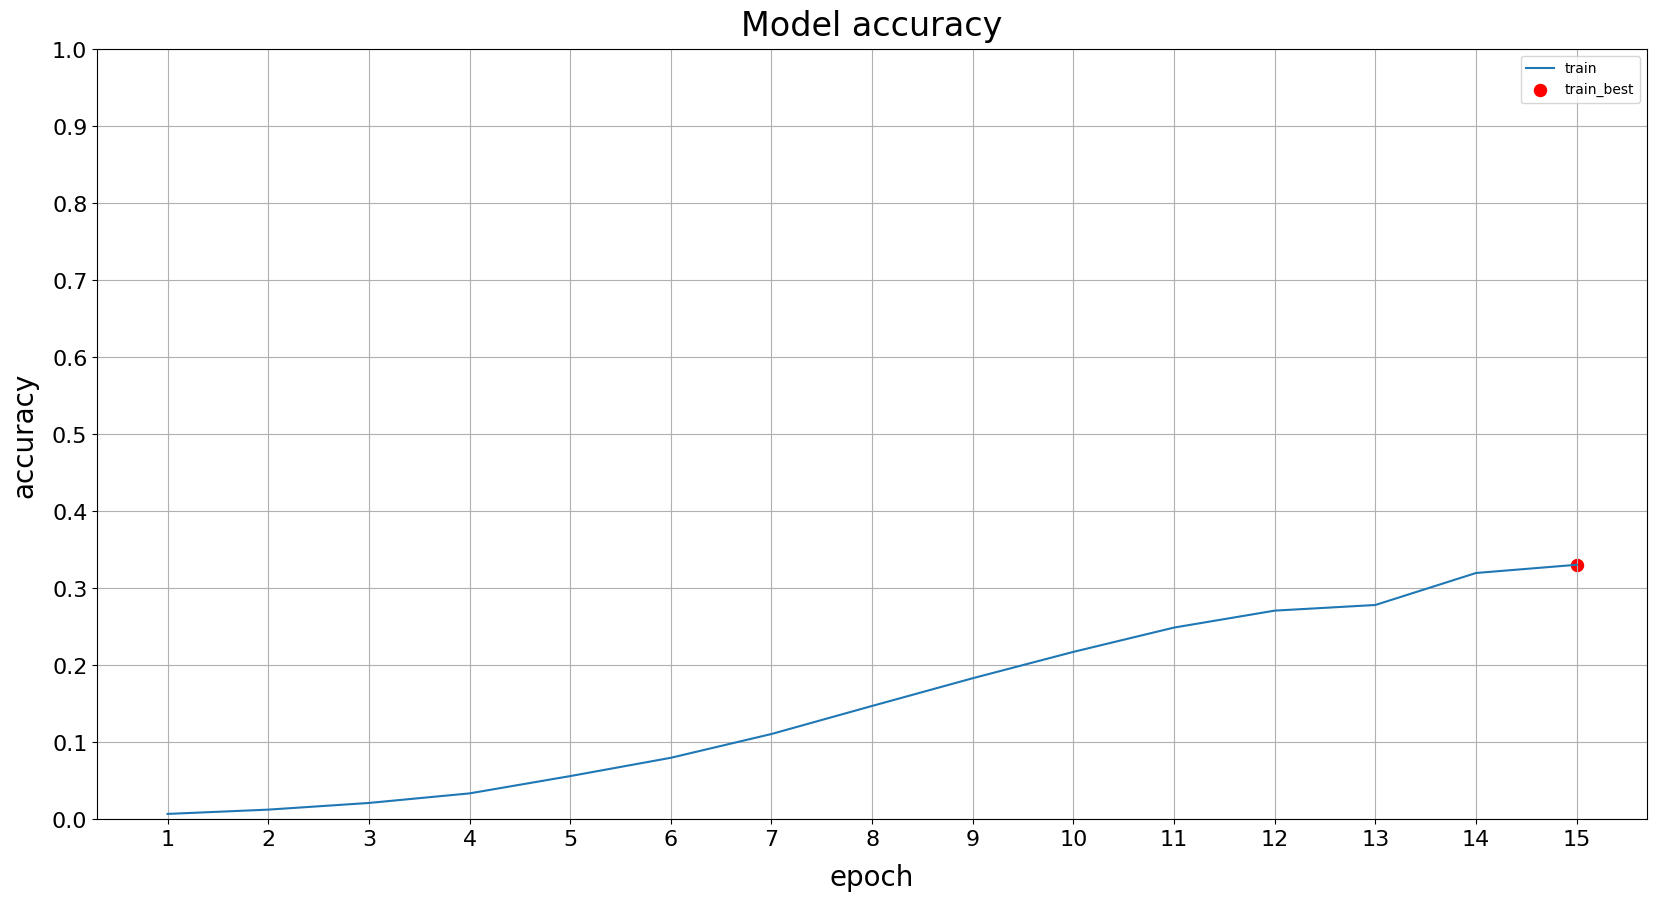

In [ ]:
plot_history_metric('accuracy', ylim=[0,1], yticks=np.arange(0.0, 1.1, 0.1))


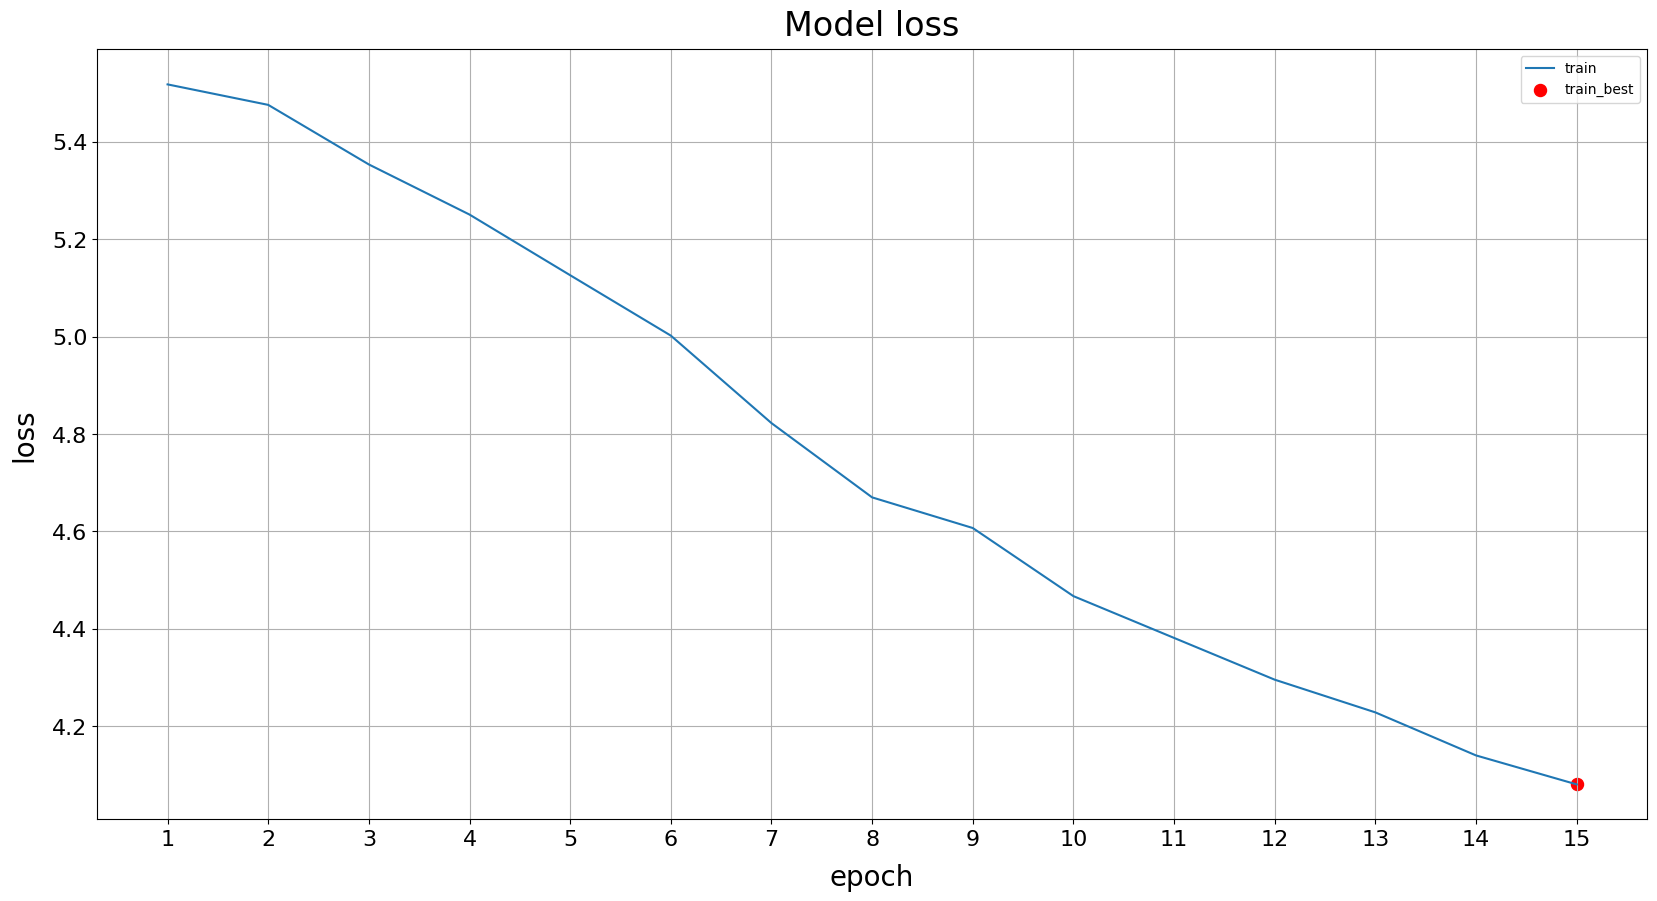

In [ ]:
plot_history_metric('loss', f_best=np.argmin)

In [ ]:
import tensorflow as tf

### LIVE PREDICTION 

In [ ]:
# Validation Predictions
y_val_pred = lstm_model.predict({ 'frames': X_val, 'non_empty_frame_idxs': NON_EMPTY_FRAME_IDXS_VAL }, verbose=2).argmax(axis=1)
# Label
labels = [ORD2SIGN.get(i).replace(' ', '_') for i in range(NUM_CLASSES)]

In [ ]:
def insert_missing_landmarks(frame_number, hand_type, num_landmarks=21):
    """Helper function to insert NaN values for missing landmarks"""
    missing_data = []
    for _ in range(num_landmarks):
        missing_data.append({'frame': frame_number, 'type': hand_type, 'x': float('nan'), 'y': float('nan'), 'z': float('nan')})
    return missing_data

def extract_frames_and_landmarks(video_path):
    mp_hands = mp.solutions.hands
    mp_face = mp.solutions.face_mesh
    mp_pose = mp.solutions.pose
    hands = mp_hands.Hands()
    face = mp_face.FaceMesh()
    pose = mp_pose.Pose()

    cap = cv2.VideoCapture(video_path)

    # frames = []
    valid_data_list = []  # Store each row as a dictionary in this list

    frame_number = 1

    while cap.isOpened():
        ret, frame = cap.read()

        if not ret:
            break
        
        # frames.append(frame)

        # Convert the BGR frame to RGB for MediaPipe
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        hand_results = hands.process(rgb_frame)
        face_results = face.process(rgb_frame)
        pose_results = pose.process(rgb_frame)

        detected_hand_types = set()  # Keep track of detected hand types in this frame
        data_list = []
        if hand_results.multi_hand_landmarks:
            for index, hand_landmark in enumerate(hand_results.multi_hand_landmarks):
                # Determine the hand type (Left or Right)
                if hand_results.multi_handedness[index].classification[0].label == "Right":
                    hand_type = "right_hand"
                else:
                    hand_type = "left_hand"
                detected_hand_types.add(hand_type)  # Add the detected hand type to the set
                hand_coords = [(lm.x, lm.y, lm.z) for lm in hand_landmark.landmark]
                for x, y, z in hand_coords:
                    data_list.append({'frame': frame_number, 'type': hand_type, 'x': x, 'y': y, 'z': z})
        
        # If left or right hand landmarks are missing, insert NaN values
        if 'left_hand' not in detected_hand_types:
            data_list.extend(insert_missing_landmarks(frame_number, 'left_hand'))
        if 'right_hand' not in detected_hand_types:
            data_list.extend(insert_missing_landmarks(frame_number, 'right_hand'))


        if face_results.multi_face_landmarks:
            face_landmarks = [[(lm.x, lm.y, lm.z) for lm in face_landmark.landmark] for face_landmark in face_results.multi_face_landmarks]
            for landmarks in face_landmarks:
                for x, y, z in landmarks:
                    data_list.append({'frame': frame_number, 'type': 'face', 'x': x, 'y': y, 'z': z})

        if pose_results.pose_landmarks:
            pose_landmarks = [(lm.x, lm.y, lm.z) for lm in pose_results.pose_landmarks.landmark]
            for x, y, z in pose_landmarks:
                data_list.append({'frame': frame_number, 'type': 'pose', 'x': x, 'y': y, 'z': z})

        if len(data_list) == 543: 
            valid_data_list.extend(data_list)
        frame_number += 1

    cap.release()
    cv2.destroyAllWindows()

    # Convert data_list to DataFrame
    df = pd.DataFrame(valid_data_list)
    return df

df = extract_frames_and_landmarks(video_path)


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [ ]:
ROWS_PER_FRAME = 543  # number of landmarks per frame

def dataframe_to_array(df):
    data_columns = ['x', 'y', 'z']
    relevant_data = df[data_columns]
    n_frames = int(len(relevant_data) / ROWS_PER_FRAME)
    
    # Ensure that the data can be divided into complete frames
    assert len(relevant_data) == n_frames * ROWS_PER_FRAME, "Mismatch in expected number of landmarks"
    
    data_array = relevant_data.values.reshape(n_frames, ROWS_PER_FRAME, len(data_columns))
    return data_array.astype(np.float32)    

# Call the function
data = dataframe_to_array(df)

In [ ]:
frame, non_empty_frames = layerInstance(data)
frame = np.expand_dims(frame, axis=0)
non_empty_frames = np.expand_dims(non_empty_frames, axis=0)
prediction = transformer_model.predict({ 'frames': frame, 'non_empty_frame_idxs': non_empty_frames }, verbose=2).argmax(axis=1)

# Get label
predicted_label = ORD2SIGN.get(prediction[0]).replace(' ', '_')

print("Predicted Label:", predicted_label)

In [ ]:
def extract_frames_and_landmarks(video_path):
    mp_hands = mp.solutions.hands
    mp_face = mp.solutions.face_mesh
    mp_pose = mp.solutions.pose
    hands = mp_hands.Hands()
    face = mp_face.FaceMesh()
    pose = mp_pose.Pose()

    cap = cv2.VideoCapture(video_path)

    frame_number = 1

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        # Convert the BGR frame to RGB for MediaPipe
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        hand_results = hands.process(rgb_frame)

        landmarks_data = []

        if hand_results.multi_hand_landmarks:
            for hand_landmark in hand_results.multi_hand_landmarks:
                for lm in hand_landmark.landmark:
                    landmarks_data.append([lm.x, lm.y, lm.z])
                    # Plot landmarks on the video frame
                    x, y = int(lm.x * frame.shape[1]), int(lm.y * frame.shape[0])
                    cv2.circle(frame, (x, y), 5, (0, 255, 0), -1)

        # Reshape landmarks_data and preprocess if necessary
        landmarks_data = np.array(landmarks_data).reshape(1, -1)  # The shape might need adjustments based on your model's input requirements

        # Predict
        pred = transformer_model.predict(landmarks_data)
        sign = ...  # Extract the sign from the prediction using your preferred logic

        # Display prediction on video
        cv2.putText(frame, f"Prediction: {sign}", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)

        # Display the video frame with landmarks and prediction
        cv2.imshow('Live Prediction', frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

        frame_number += 1

    cap.release()
    cv2.destroyAllWindows()


### LIVE VIDEO 


In [22]:
# Load model
custom_objects = {'scce_with_ls': scce_with_ls}  # Fill with any custom objects if required
transformer_model = tf.keras.models.load_model("model/full_transformer_model", custom_objects=custom_objects)
lstm_model = tf.keras.models.load_model("model/full_lstm_model", custom_objects=custom_objects)

In [ ]:
import cv2
import mediapipe as mp
import numpy as np
import tensorflow as tf
from collections import deque


def extract_frames_and_landmarks(video_path):
    mp_hands = mp.solutions.hands
    mp_face = mp.solutions.face_mesh
    mp_pose = mp.solutions.pose
    hands = mp_hands.Hands()
    face = mp_face.FaceMesh()
    pose = mp_pose.Pose()
    WINDOW_SIZE  = 50
    cap = cv2.VideoCapture(video_path)

    landmarks_storage = deque(maxlen=WINDOW_SIZE) # Store landmarks for each frame here
    last_prediction = None

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Convert the BGR frame to RGB for MediaPipe
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        hand_results = hands.process(rgb_frame)
        face_results = face.process(rgb_frame)
        pose_results = pose.process(rgb_frame)

        frame_landmarks = []  # Store landmarks for this particular frame

        # Extract and Draw Hand landmarks
        if hand_results.multi_hand_landmarks:
            for hand_landmark in hand_results.multi_hand_landmarks:
                frame_landmarks.extend([(lm.x, lm.y, lm.z) for lm in hand_landmark.landmark])
                mp.solutions.drawing_utils.draw_landmarks(frame, hand_landmark, mp_hands.HAND_CONNECTIONS)

        # Extract and Draw Face landmarks
        if face_results.multi_face_landmarks:
            for face_landmark in face_results.multi_face_landmarks:
                frame_landmarks.extend([(lm.x, lm.y, lm.z) for lm in face_landmark.landmark])
                mp.solutions.drawing_utils.draw_landmarks(frame, face_landmark)

        # Extract and Draw Pose landmarks
        if pose_results.pose_landmarks:
            pose_landmark = pose_results.pose_landmarks
            frame_landmarks.extend([(lm.x, lm.y, lm.z) for lm in pose_landmark.landmark])
            mp.solutions.drawing_utils.draw_landmarks(frame, pose_landmark, mp_pose.POSE_CONNECTIONS)

        # Assuming the combined landmarks for hands, face, and pose is 543
        if len(frame_landmarks) == 543:
            landmarks_storage.append(frame_landmarks)

            if len(landmarks_storage) == WINDOW_SIZE:
                landmarks_data = np.array(landmarks_storage)

                # Reshape landmarks and preprocess if necessary
                landmarks_data = np.array(landmarks_storage)
                frames, non_empty_frames = layerInstance(landmarks_data)
                frames = np.expand_dims(frames, axis=0)
                non_empty_frames = np.expand_dims(non_empty_frames, axis=0)
                print(frames.shape)

                raw_output = lstm_model.predict({'frames': frames, 'non_empty_frame_idxs': non_empty_frames }, verbose=2)
                pred_idx = raw_output.argmax(axis = 1)
                confidence = raw_output[0][pred_idx[0]]
                print(confidence)
                sign = ORD2SIGN[pred_idx[0]]
                # predicted_sign_names = [ORD2SIGN[label] for label in pred]
                # sign = predicted_label   # Extract the sign from the prediction using your preferred logic
                print(sign)
                last_prediction = f'{sign} (Confidence Level : {confidence:.2f})'
                # Display prediction on video
        if last_prediction:
            cv2.putText(frame, f"Prediction: {last_prediction}", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)


        # Display the video frame with landmarks and prediction
        cv2.imshow('Live Prediction', frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

extract_frames_and_landmarks(video_path = 'data/IMG_7131.MOV')

In [23]:
def insert_missing_landmarks(frame_number, hand_type, num_landmarks=21):
    """Helper function to insert NaN values for missing landmarks"""
    missing_data = []
    for _ in range(num_landmarks):
        missing_data.append({'frame': frame_number, 'type': hand_type, 'x': float('nan'), 'y': float('nan'), 'z': float('nan')})
    return missing_data

def dataframe_to_array(df):
    data_columns = ['x', 'y', 'z']
    relevant_data = df[data_columns]
    n_frames = int(len(relevant_data) / ROWS_PER_FRAME)
      
    data_array = relevant_data.values.reshape(n_frames, ROWS_PER_FRAME, len(data_columns))

    print(f'data_array shape: {data_array.shape}')

    return data_array.astype(np.float32)    

def predict_signs(fram, non_empty_frame, model):    
    """Predict signs using the provided model."""
    predictions = model.predict({'frames': fram, 'non_empty_frame_idxs': non_empty_frame}, verbose=2)
    return predictions

In [26]:
from collections import deque

In [31]:
def main(video_path, model):
    mp_hands = mp.solutions.hands
    mp_face = mp.solutions.face_mesh
    mp_pose = mp.solutions.pose
    hands = mp_hands.Hands()
    face = mp_face.FaceMesh()
    pose = mp_pose.Pose()
    WINDOW_SIZE = 50
    cap = cv2.VideoCapture(video_path)

    landmarks_storage = deque(maxlen = WINDOW_SIZE)  # Store landmarks for each frame here
    last_prediction = None
    last_valid_frame = None
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            if last_valid_frame is not None:
                if last_prediction:
                    cv2.putText(last_valid_frame, f"Prediction: {last_prediction}", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)
                cv2.imshow('Live Prediction', last_valid_frame)  # Show the last frame
                cv2.waitKey(10000)  # Wait for 10 seconds
            break
        last_valid_frame = frame
        # Convert the BGR frame to RGB for MediaPipe
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        hand_results = hands.process(rgb_frame)
        face_results = face.process(rgb_frame)
        pose_results = pose.process(rgb_frame)

        frame_landmarks = []  # Store landmarks for this particular frame

        # Extract and Draw Hand landmarks
        if hand_results.multi_hand_landmarks:
            for hand_landmark in hand_results.multi_hand_landmarks:
                frame_landmarks.extend([(lm.x, lm.y, lm.z) for lm in hand_landmark.landmark])
                mp.solutions.drawing_utils.draw_landmarks(frame, hand_landmark, mp_hands.HAND_CONNECTIONS)

        # Extract and Draw Face landmarks
        if face_results.multi_face_landmarks:
            for face_landmark in face_results.multi_face_landmarks:
                frame_landmarks.extend([(lm.x, lm.y, lm.z) for lm in face_landmark.landmark])
                mp.solutions.drawing_utils.draw_landmarks(frame, face_landmark)

        # Extract and Draw Pose landmarks
        if pose_results.pose_landmarks:
            pose_landmark = pose_results.pose_landmarks
            frame_landmarks.extend([(lm.x, lm.y, lm.z) for lm in pose_landmark.landmark])
            mp.solutions.drawing_utils.draw_landmarks(frame, pose_landmark, mp_pose.POSE_CONNECTIONS)

        # Assuming the combined landmarks for hands, face, and pose is 543
        if len(frame_landmarks) == 543:
            landmarks_storage.append(frame_landmarks)

            if len(landmarks_storage) == WINDOW_SIZE:
                landmarks_data = np.array(landmarks_storage)
                landmarks_data = np.array(landmarks_storage)
                frames, non_empty_frames = layerInstance(landmarks_data)
                frames = np.expand_dims(frames, axis=0)
                non_empty_frames = np.expand_dims(non_empty_frames, axis=0)
                raw_output = predict_signs(frames, non_empty_frames, model)
                pred_idx = raw_output.argmax(axis = 1)
                confidence = raw_output[0][pred_idx[0]]
                print(confidence)
                sign = ORD2SIGN[pred_idx[0]]                
                last_prediction = f'{sign} (Confidence Level : {confidence:.2f})'

                # Display prediction on video
        # if last_prediction:
        #     cv2.putText(frame, f"Prediction: {last_prediction}", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2, cv2.LINE_AA)
        # Display the video frame with landmarks and prediction
        cv2.imshow('Live Prediction', frame)
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

main('data/IMG_7131.MOV', lstm_model)

1/1 - 0s - 50ms/epoch - 50ms/step
0.09610728
1/1 - 0s - 51ms/epoch - 51ms/step
0.09399122
1/1 - 0s - 57ms/epoch - 57ms/step
0.09161613
1/1 - 0s - 52ms/epoch - 52ms/step
0.08927183
1/1 - 0s - 54ms/epoch - 54ms/step
0.08692158
1/1 - 0s - 51ms/epoch - 51ms/step
0.08511207
1/1 - 0s - 51ms/epoch - 51ms/step
0.08300001
1/1 - 0s - 51ms/epoch - 51ms/step
0.08137151
1/1 - 0s - 52ms/epoch - 52ms/step
0.07926879
1/1 - 0s - 53ms/epoch - 53ms/step
0.077457175
1/1 - 0s - 54ms/epoch - 54ms/step
0.076009214
1/1 - 0s - 52ms/epoch - 52ms/step
0.07510485
1/1 - 0s - 63ms/epoch - 63ms/step
0.074814744
1/1 - 0s - 53ms/epoch - 53ms/step
0.07491082
1/1 - 0s - 74ms/epoch - 74ms/step
0.07542099
1/1 - 0s - 52ms/epoch - 52ms/step
0.07628537


: 